In [13]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

In [14]:
import torch
from transformers import SamModel, SamProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [19]:
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0): SamVisionLayer(
        (layer_norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (layer_norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELUActivation()
        )
      )
      (1): SamVisionLayer(
        (layer_norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (q

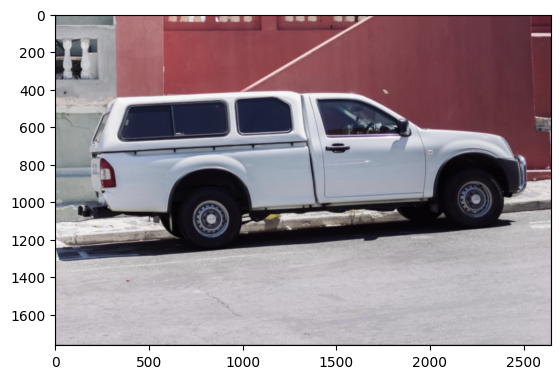

In [ ]:
from PIL import Image
import requests

img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

plt.imshow(raw_image)

In [15]:
inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

In [ ]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [ ]:
show_masks_on_image(raw_image, masks[0], scores)